In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm
import sympy.physics.mechanics as me
from pydy.system import System
from pydy.viz import Cylinder, Plane, VisualizationFrame, Scene

In [2]:
%matplotlib inline

In [3]:
me.init_vprinting(use_latex='mathjax')

In [4]:
mA, mB, lB, w, h, g = sm.symbols('m_A, m_B, L_B, w, h, g')

In [5]:
theta, phi = me.dynamicsymbols('theta, phi')
omega, alpha = me.dynamicsymbols('omega, alpha')

In [6]:
kin_diff = (omega - theta.diff(), alpha - phi.diff())
kin_diff

(ω - θ̇, α - φ̇)

In [7]:
N = me.ReferenceFrame('N')
A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')

In [8]:
A.orient(N, 'Axis', (theta, N.y))
B.orient(A, 'Axis', (phi, A.z))

In [9]:
No = me.Point('No')
Ao = me.Point('Ao')
Bo = me.Point('Bo')

In [10]:
lA = (lB - h / 2) / 2
Ao.set_pos(No, lA * A.z)
Bo.set_pos(No, lB * A.z)

In [11]:
A.set_ang_vel(N, omega * N.y)
B.set_ang_vel(A, alpha * A.z)

In [12]:
No.set_vel(N, 0)

In [13]:
Ao.v2pt_theory(No, N, A)

⎛L_B   h⎞
⎜─── - ─⎟⋅ω a_x
⎝ 2    4⎠

In [14]:
Bo.v2pt_theory(No, N, A)

L_B⋅ω a_x

In [15]:
IAxx = sm.S(1) / 12 * mA * (2 * lA)**2
IAyy = IAxx
IAzz = 0

IA = (me.inertia(A, IAxx, IAyy, IAzz), Ao)

In [16]:
IA[0].to_matrix(A)

⎡             2                   ⎤
⎢    ⎛      h⎞                    ⎥
⎢m_A⋅⎜L_B - ─⎟                    ⎥
⎢    ⎝      2⎠                    ⎥
⎢──────────────        0         0⎥
⎢      12                         ⎥
⎢                                 ⎥
⎢                             2   ⎥
⎢                    ⎛      h⎞    ⎥
⎢                m_A⋅⎜L_B - ─⎟    ⎥
⎢                    ⎝      2⎠    ⎥
⎢      0         ──────────────  0⎥
⎢                      12         ⎥
⎢                                 ⎥
⎣      0               0         0⎦

In [17]:
IBxx = sm.S(1)/12 * mB * h**2
IByy = sm.S(1)/12 * mB * (w**2 + h**2)
IBzz = sm.S(1)/12 * mB * w**2

IB = (me.inertia(B, IBxx, IByy, IBzz), Bo)

In [18]:
IB[0].to_matrix(B)

⎡ 2                           ⎤
⎢h ⋅m_B                       ⎥
⎢──────        0          0   ⎥
⎢  12                         ⎥
⎢                             ⎥
⎢            ⎛ 2    2⎞        ⎥
⎢        m_B⋅⎝h  + w ⎠        ⎥
⎢  0     ─────────────    0   ⎥
⎢              12             ⎥
⎢                             ⎥
⎢                            2⎥
⎢                       m_B⋅w ⎥
⎢  0           0        ──────⎥
⎣                         12  ⎦

In [19]:
rod = me.RigidBody('rod', Ao, A, mA, IA)

In [20]:
plate = me.RigidBody('plate', Bo, B, mB, IB)

In [21]:
rod_gravity = (Ao, mA * g * N.z)
plate_gravity = (Bo, mB * g * N.z)

In [22]:
kane = me.KanesMethod(N, q_ind=(theta, phi), u_ind=(omega, alpha), kd_eqs=kin_diff)

In [23]:
bodies = (rod, plate)
loads = (rod_gravity, plate_gravity)

fr, frstar = kane.kanes_equations(bodies, loads)

In [24]:
sm.trigsimp(fr)

⎡  ⎛  L_B⋅m_A             h⋅m_A⎞       ⎤
⎢g⋅⎜- ─────── - L_B⋅m_B + ─────⎟⋅sin(θ)⎥
⎢  ⎝     2                  4  ⎠       ⎥
⎢                                      ⎥
⎣                  0                   ⎦

In [25]:
sm.trigsimp(frstar)

⎡     2                ⎛   2                               2        2         
⎢m_B⋅w ⋅α⋅ω⋅sin(2⋅φ)   ⎜L_B ⋅m_A      2       L_B⋅h⋅m_A   h ⋅m_A   h ⋅m_B   m_
⎢─────────────────── - ⎜──────── + L_B ⋅m_B - ───────── + ────── + ────── + ──
⎢         12           ⎝   3                      3         12       12       
⎢                                                                             
⎢                                      2 ⎛ 2               ⎞                  
⎢                                -m_B⋅w ⋅⎝ω ⋅sin(2⋅φ) + 2⋅α̇⎠                 
⎢                                ────────────────────────────                 
⎣                                             24                              

   2    2   ⎞  ⎤
B⋅w ⋅cos (φ)⎟  ⎥
────────────⎟⋅ω̇⎥
    12      ⎠  ⎥
               ⎥
               ⎥
                ⎥
               ⎥
               ⎦

In [26]:
sys = System(kane)

In [27]:
sys.constants = {lB: 0.2, # meters
                 h: 0.1, # meters
                 w: 0.2, # meters
                 mA: 0.01, # kilograms
                 mB: 0.1, # kilograms
                 g: 9.81} # meters per second squared

In [28]:
sys.initial_conditions = {theta: np.deg2rad(45),
                          phi: np.deg2rad(0.5),
                          omega: 0,
                          alpha: 0}

In [29]:
sys.times = np.linspace(0.0, 10.0, num=300)

In [30]:
x = sys.integrate()

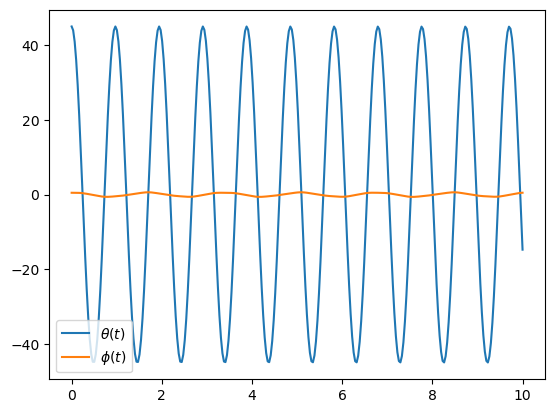

In [31]:
def plot():
    plt.figure()
    plt.plot(sys.times, np.rad2deg(x[:, :2]))
    plt.legend([sm.latex(s, mode='inline') for s in sys.coordinates])

plot()

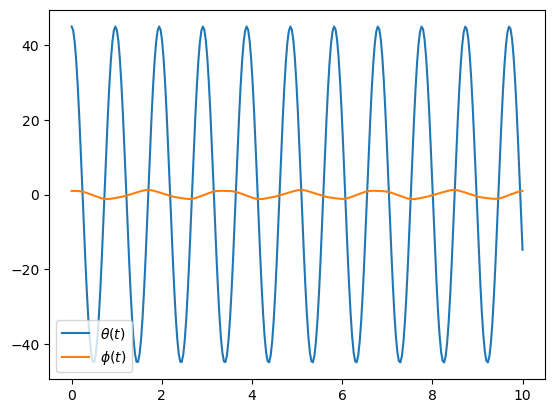

In [32]:
sys.initial_conditions[phi] = np.deg2rad(1.0)
x = sys.integrate()
plot()

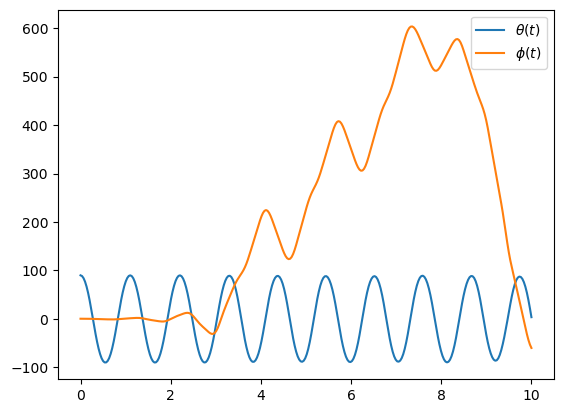

In [33]:
sys.initial_conditions[theta] = np.deg2rad(90)
sys.initial_conditions[phi] = np.deg2rad(0.5)
x = sys.integrate()
plot()

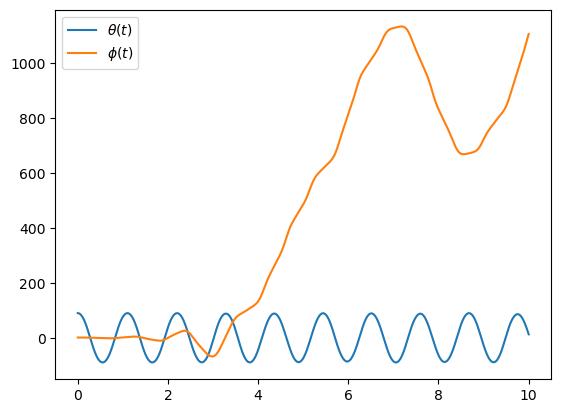

In [34]:
sys.initial_conditions[phi] = np.deg2rad(1.0)
x = sys.integrate()
plot()

In [35]:
rod_shape = Cylinder(2 * lA, 0.005, color='red', name='rod')
plate_shape = Plane(w, h, color='blue', name='plate')

v1 = VisualizationFrame('rod',
                        A.orientnew('rod', 'Axis', (sm.pi / 2, A.x)),
                        Ao,
                        rod_shape)

v2 = VisualizationFrame('plate',
                        B.orientnew('plate', 'Body', (sm.pi / 2, sm.pi / 2, 0), 'XZX'),
                        Bo,
                        plate_shape)

scene = Scene(N, No, v1, v2, system=sys)

In [36]:
scene.display_jupyter(axes_arrow_length=1.0)